In [103]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib

# Q1

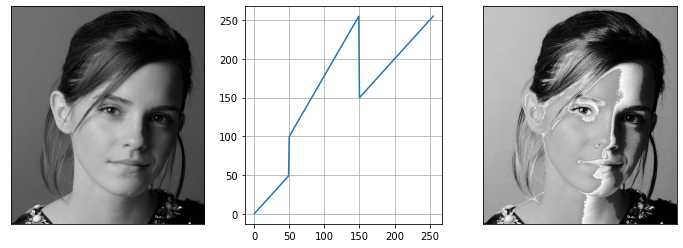

In [11]:
inp_img = cv.imread("assets/emma_gray.jpg", cv.IMREAD_GRAYSCALE)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

t1 = np.arange(0, 50, 1)
t2 = np.linspace(100, 255, 100)
t3 = np.arange(150, 256, 1)
t = np.hstack((t1, t2, t3))

out_img = cv.LUT(inp_img, t)

ax[0].imshow(inp_img, cmap="gray")
ax[1].plot(t)
ax[2].imshow(out_img, cmap="gray")

for i in [0, 2]:
    ax[i].set_xticks([])
    ax[i].set_yticks([])
ax[1].grid(True)

plt.show()

# Q2

In [53]:
def tanh_f(x):
    num = np.exp(x) - np.exp(-x)
    den = np.exp(x) + np.exp(-x)
    return num/den

def accentuating_transformation(center, width):
    center = center
    width = width
    x = np.linspace(center-width, center+width, 256)
    tanh = tanh_f(x)
    max_val = np.max([np.max(tanh), np.abs(np.min(tanh))])
    scaled_f = tanh/max_val*127.5
    shifted_f = scaled_f + 127.5
    quantized_f = np.round(shifted_f).astype(np.uint8)
    
    return quantized_f


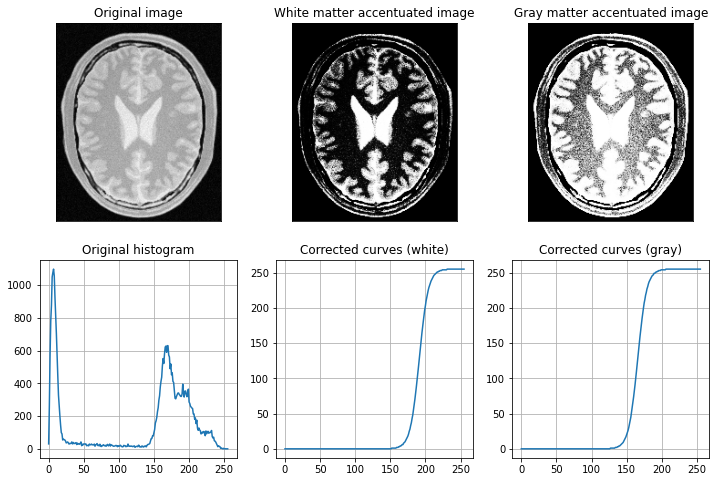

In [72]:
inp_img = cv.imread("assets/brain_proton_density_slice.png")

orig_hist = cv.calcHist([inp_img], [0], None, [256], [0,256])

white_trans = accentuating_transformation(-5, 10)
gray_trans = accentuating_transformation(-3, 10)

white_img = cv.LUT(inp_img, white_trans)
gray_img = cv.LUT(inp_img, gray_trans)

fig, ax = plt.subplots(2, 3, figsize=(12, 8))

ax[0][0].imshow(inp_img)
ax[0][1].imshow(white_img)
ax[0][2].imshow(gray_img)
ax[1][0].plot(orig_hist)
ax[1][1].plot(white_trans)
ax[1][2].plot(gray_trans)

for i in range(3):
    ax[0][i].set_xticks([])
    ax[0][i].set_yticks([])
    ax[1][i].grid(True)

ax[0][0].set_title("Original image")
ax[0][1].set_title("White matter accentuated image")
ax[0][2].set_title("Gray matter accentuated image")
ax[1][0].set_title("Original histogram")
ax[1][1].set_title("Corrected curves (white)")
ax[1][2].set_title("Corrected curves (gray)")

plt.show()

# Q3

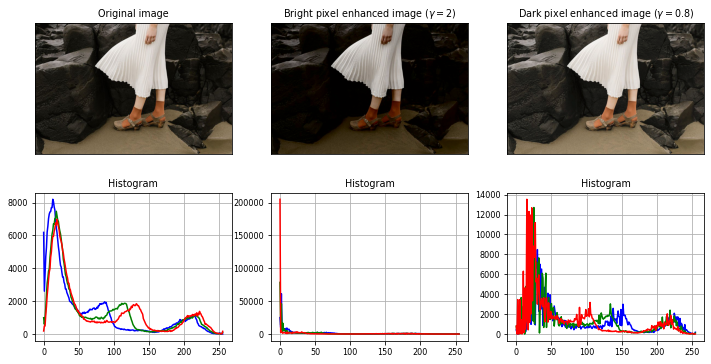

In [130]:
font = {'size'   : 8}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(2,3,figsize=(12,6))

inp_img = cv.imread("assets/highlights_and_shadows.jpg")
disp_inp_img = cv.cvtColor(inp_img, cv.COLOR_BGR2RGB)

# find color corrections
gamma_light = 2
t_light = np.array([(p/255)**gamma_light*255 for p in range(256)]).astype(np.uint8)
gamma_dark = 0.8
t_dark = np.array([(p/255)**gamma_dark*255 for p in range(256)]).astype(np.uint8)

# find light image
LAB_light_img = cv.cvtColor(inp_img, cv.COLOR_BGR2LAB)
LAB_light_img[:,:,0] = cv.LUT(LAB_light_img[:,:,0], t_light)
disp_corrected_light_img = cv.cvtColor(LAB_light_img, cv.COLOR_LAB2RGB)

# find dark image
LAB_dark_img = cv.cvtColor(inp_img, cv.COLOR_BGR2LAB)
LAB_dark_img[:,:,0] = cv.LUT(LAB_dark_img[:,:,0], t_dark)
disp_corrected_dark_img = cv.cvtColor(LAB_dark_img, cv.COLOR_LAB2RGB)

colors = ('b', 'g', 'r')

# Original image
ax[0][0].imshow(disp_inp_img)
for i, c in enumerate(colors):
  color_hist = cv.calcHist([inp_img], [i], None, [256], [0,256])
  ax[1][0].plot(color_hist, color=c)

# Light image
ax[0][1].imshow(disp_corrected_light_img)
for i, c in enumerate(colors):
  color_hist = cv.calcHist([disp_corrected_light_img], [i], None, [256], [0,256])
  ax[1][1].plot(color_hist, color=c)

# Dark image
ax[0][2].imshow(disp_corrected_dark_img)
for i, c in enumerate(colors):
  color_hist = cv.calcHist([disp_corrected_dark_img], [i], None, [256], [0,256])
  ax[1][2].plot(color_hist, color=c)

ax[0][0].set_title("Original image")
ax[0][1].set_title(f"Bright pixel enhanced image $(\gamma={gamma_light})$")
ax[0][2].set_title(f"Dark pixel enhanced image $(\gamma={gamma_dark})$")

for j in range(3):
    ax[0][j].set_xticks([])
    ax[0][j].set_yticks([])
    ax[1][j].grid(True)
    ax[1][j].set_title("Histogram")


plt.show()

# Q4

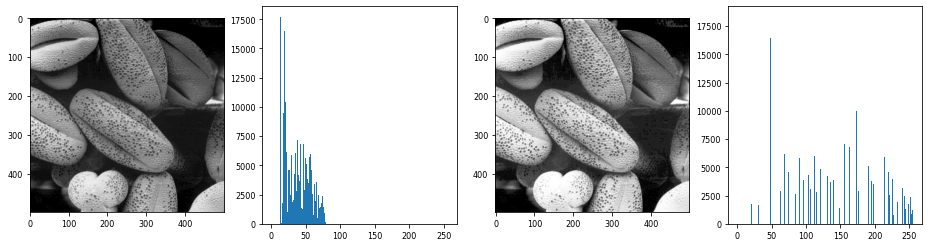

In [137]:
def getHistBalImg(img):
  L = 256
  MN = img.size
  return_img = np.zeros(img.shape, dtype='uint8')

  intensity_bins = np.zeros(L)
  for i in range(L):
    intensity_bins[i] = img[img==i].size

  cum_intensity_bins = intensity_bins.cumsum()
  scaled_cum_intensity_bins = (L-1)/MN*cum_intensity_bins
  
  return_img = scaled_cum_intensity_bins[img]

  return return_img

unbal_img = cv.imread('assets/shells.png', cv.IMREAD_GRAYSCALE)
assert unbal_img is not None
bal_img = getHistBalImg(unbal_img)

fig, ax = plt.subplots(1, 4, figsize=(16,4))

ax[0].imshow(unbal_img, cmap='gray')
ax[1].hist(unbal_img.flatten(), 256, [0, 256])
ax[2].imshow(bal_img, cmap='gray')
ax[3].hist(bal_img.flatten(), 256, [0, 256])

plt.show()

# Q5

In [164]:
def zoomImg(inp_img, scale, zoom_type):
    '''
    zoom_type may take the two values 0 and 1
        0: Will zoom with nearest neighbour method
        1: Will zoom with bilinear interpolation
    '''
    rows = inp_img.shape[0]*scale
    cols = inp_img.shape[1]*scale
    
    out_img = np.zeros((rows, cols))

    if (zoom_type == 0):
        for i in range(rows):
            for j in range(cols):
                out_img[i][j] = inp_img[np.round(i/scale).astype(int)-1][np.round(j/scale).astype(int)-1]
    else:
        # p1      p2
        # x1   x  x2
        # 
        # p3      p4
        for i in range(rows):
            for j in range(cols):
                p1 = inp_img[int(i/scale)][int(j/scale)]
                p2 = inp_img[int(i/scale)+1][int(j/scale)]
                p3 = inp_img[int(i/scale)][int(j/scale)+1]
                p4 = inp_img[int(i/scale)+1][int(j/scale)+1]

                x1 = p1*(int(j/scale)+1-j/scale)+p3*(j/scale-int(j/scale))
                x2 = p2*(int(j/scale)+1-j/scale)+p4*(j/scale-int(j/scale))
                x = x2*(i/scale - int(i/scale))+x1*(int(i/scale)+1-i/scale)

                out_img[i][j] = x
        out_img = np.round(out_img).astype(int)
        
    return out_img

In [165]:
inp_img = cv.imread("assets/shells.png", cv.IMREAD_REDUCED_GRAYSCALE_2)
scale = 4
out_nn_img = zoomImg(inp_img, scale, 0)
out_bi_img = zoomImg(inp_img, scale, 1)

fig, ax = plt.subplots(1, 3, figsize=(9, 3))

ax[0].imshow(inp_img, cmap='gray')
ax[1].imshow(out_nn_img, cmap='gray')
ax[2].imshow(out_bi_img, cmap='gray')

ax[0].set_title("Original image")
ax[1].set_title("Image zoomed with Nearest Neighbour Method")
ax[2].set_title("Image zoomed with Bilinear Interpolation")

for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_yticks([])

fig.tight_layout()

plt.show()